# Sellers

Another category analyzed from the Olist dataset is sellers. The database even has a dedicated 'sellers' table with data on each seller. Olist is a marketplace platform that connects sellers directly with individual customers.

In this analysis, we will look for an answer to the following questions:
- How many sellers are on the platform and where are they from?
- Who sells the most and what products?
- What is the distribution of sellers in terms of revenue?


Importing Python libraries in order to make some possible visualizations.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Establishing connection to the database.

In [1]:
%load_ext sql
%sql sqlite:///data/olist.db

'Connected: @data/olist.db'

### How many sellers are on the platform and where are they from?

Finding how many individual sellers are on the platform:

In [2]:
%%sql
SELECT COUNT(DISTINCT seller_id) AS sellers_number FROM sellers;

 * sqlite:///olist.db
Done.


sellers_number
3095


TOP 10 cities in Brazil with the most sellers:

In [3]:
%%sql
SELECT seller_city, COUNT(DISTINCT seller_id) AS sellers_number FROM sellers
GROUP BY seller_city
ORDER BY sellers_number DESC
LIMIT 10; 

 * sqlite:///olist.db
Done.


seller_city,sellers_number
sao paulo,694
curitiba,127
rio de janeiro,96
belo horizonte,68
ribeirao preto,52
guarulhos,50
ibitinga,49
santo andre,45
campinas,41
maringa,40


How many different cities are the sellers from:

In [4]:
%%sql
SELECT COUNT(DISTINCT seller_city) AS city_number FROM sellers;

 * sqlite:///olist.db
Done.


city_number
611


### Who sells the most and what products?

Below is a list of the TOP 10 sellers in terms of total revenue on the platform. The table also contains information about the amount of all products sold, the city and state of the seller.

In [44]:
%%sql 
SELECT o.seller_id, COUNT(product_id) AS products_sold, seller_city, seller_state, ROUND(SUM(price),2) AS total_revenue FROM order_items o 
LEFT JOIN sellers s ON o.seller_id=s.seller_id 
GROUP BY o.seller_id
ORDER BY total_revenue DESC
LIMIT 10; 

 * sqlite:///olist.db
Done.


seller_id,products_sold,seller_city,seller_state,total_revenue
4869f7a5dfa277a7dca6462dcf3b52b2,1156,guariba,SP,229472.63
53243585a1d6dc2643021fd1853d8905,410,lauro de freitas,BA,222776.05
4a3ca9315b744ce9f8e9374361493884,1987,ibitinga,SP,200472.92
fa1c13f2614d7b5c4749cbc52fecda94,586,sumare,SP,194042.03
7c67e1448b00f6e969d365cea6b010ab,1364,itaquaquecetuba,SP,187923.89
7e93a43ef30c4f03f38b393420bc753a,340,barueri,SP,176431.87
da8622b14eb17ae2831f4ac5b9dab84a,1551,piracicaba,SP,160236.57
7a67c85e85bb2ce8582c35f2203ad736,1171,sao paulo,SP,141745.53
1025f0e2d44d7041d6cf58b6550e0bfa,1428,sao paulo,SP,138968.55
955fee9216a65b617aa5c0531780ce60,1499,sao paulo,SP,135171.7


Another interesting information is the most profitable category for each seller, the number of products in this category and the total revenue generated by these products.  
For example, the top seller (id ending with *'b2'*) made the vast majority of his sales in the watches_gifts category.

In [41]:
%%sql
SELECT seller_id, category, products_sold, total_revenue FROM
(SELECT *, RANK () OVER (
    PARTITION BY a.seller_id 
    ORDER BY a.total_revenue DESC) 
    revenue_rank FROM
(SELECT o.seller_id, t.product_category_name_english AS category, COUNT(o.product_id) AS products_sold, ROUND(SUM(o.price),2) AS total_revenue FROM order_items o
LEFT JOIN products p ON o.product_id=p.product_id
LEFT JOIN products_translation t ON p.product_category_name=t.product_category_name
GROUP BY o.seller_id, p.product_category_name) as a)
WHERE revenue_rank=1
ORDER BY total_revenue DESC
LIMIT 10;

 * sqlite:///olist.db
Done.


seller_id,category,products_sold,total_revenue
4869f7a5dfa277a7dca6462dcf3b52b2,watches_gifts,1002,201071.73
fa1c13f2614d7b5c4749cbc52fecda94,watches_gifts,579,192092.74
7c67e1448b00f6e969d365cea6b010ab,office_furniture,1233,172959.66
7e93a43ef30c4f03f38b393420bc753a,watches_gifts,314,169768.06
53243585a1d6dc2643021fd1853d8905,computers,153,166871.75
4a3ca9315b744ce9f8e9374361493884,bed_bath_table,1572,165219.25
da8622b14eb17ae2831f4ac5b9dab84a,bed_bath_table,1277,152307.8
7a67c85e85bb2ce8582c35f2203ad736,cool_stuff,1069,135413.55
1025f0e2d44d7041d6cf58b6550e0bfa,furniture_decor,1292,111530.45
1f50f920176fa81dab994f9023523100,garden_tools,1882,103133.11


We can also check the ranking of the TOP 3 sellers each year along with the total revenue.

In [4]:
%%sql
SELECT year, seller_id, revenue_rank, total_revenue FROM
(SELECT *, RANK () OVER (
    PARTITION BY a.year 
    ORDER BY a.total_revenue DESC) 
    revenue_rank FROM
(SELECT STRFTIME("%Y",o.order_purchase_timestamp) AS year, i.seller_id, ROUND(SUM(i.price),2) AS total_revenue FROM order_items i
LEFT JOIN orders o ON i.order_id=o.order_id
LEFT JOIN products p ON i.product_id=p.product_id
GROUP BY STRFTIME("%Y",o.order_purchase_timestamp), i.seller_id) as a)
WHERE revenue_rank <= 3
ORDER BY year, revenue_rank;

 * sqlite:///data/olist.db
Done.


year,seller_id,revenue_rank,total_revenue
2016,620c87c171fb2a6dd6e8bb4dec959fc6,1,5797.1
2016,822b63912576852aea9a8436d72317b7,2,2849.97
2016,46dc3b2cc0980fb8ec44634e21d2718e,3,2344.89
2017,53243585a1d6dc2643021fd1853d8905,1,181113.92
2017,7e93a43ef30c4f03f38b393420bc753a,2,159389.13
2017,4a3ca9315b744ce9f8e9374361493884,3,127584.77
2018,4869f7a5dfa277a7dca6462dcf3b52b2,1,138414.6
2018,955fee9216a65b617aa5c0531780ce60,2,117340.86
2018,7d13fca15225358621be4086e1eb0964,3,113628.97


Korzystając z poprzedniego zapytania można zgrupować dane względem roku, id sprzedawcy i kategorii produktu. Dzięki temu można sprawdzić w tabeli, jakie trzy kategorie wygenerowały największy przychód w każdym roku dla najlepszych sprzedawców. 

In [3]:
%%sql
SELECT year, seller_id, revenue_rank, category, total_revenue FROM
(SELECT *, RANK () OVER (
    PARTITION BY a.year 
    ORDER BY a.total_revenue DESC) 
    revenue_rank FROM
(SELECT STRFTIME("%Y",o.order_purchase_timestamp) AS year, i.seller_id, t.product_category_name_english AS category, ROUND(SUM(i.price),2) AS total_revenue FROM order_items i
LEFT JOIN orders o ON i.order_id=o.order_id
LEFT JOIN products p ON i.product_id=p.product_id
LEFT JOIN products_translation t ON p.product_category_name=t.product_category_name
GROUP BY STRFTIME("%Y",o.order_purchase_timestamp), i.seller_id, p.product_category_name) as a)
WHERE revenue_rank <= 3
ORDER BY year ASC, total_revenue DESC;

 * sqlite:///data/olist.db
Done.


year,seller_id,revenue_rank,category,total_revenue
2016,620c87c171fb2a6dd6e8bb4dec959fc6,1,perfumery,5407.5
2016,822b63912576852aea9a8436d72317b7,2,consoles_games,2849.97
2016,4d600e08ecbe08258c79e536c5a42fee,3,watches_gifts,1931.34
2017,7e93a43ef30c4f03f38b393420bc753a,1,watches_gifts,154299.28
2017,53243585a1d6dc2643021fd1853d8905,2,computers,147481.82
2017,4a3ca9315b744ce9f8e9374361493884,3,bed_bath_table,104082.49
2018,4869f7a5dfa277a7dca6462dcf3b52b2,1,watches_gifts,119027.0
2018,fa1c13f2614d7b5c4749cbc52fecda94,2,watches_gifts,94043.73
2018,7d13fca15225358621be4086e1eb0964,3,watches_gifts,90112.07


### What is the distribution of sellers in terms of revenue?

Using the seaborn and pandas libraries, you can easily create a histogram with the distribution of the total revenue of each seller.

 * sqlite:///data/olist.db
Done.


<AxesSubplot: xlabel='revenue', ylabel='Count'>

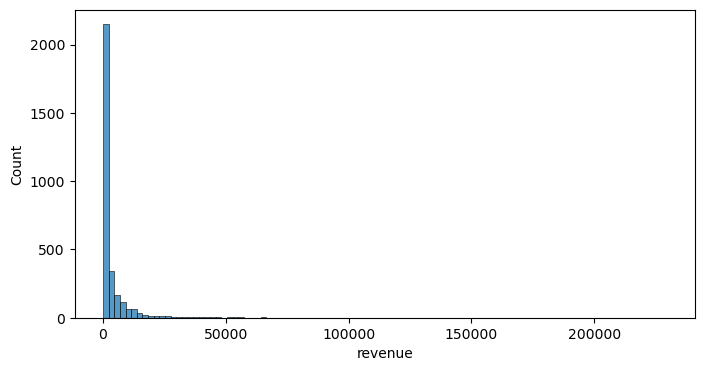

In [6]:
data = %sql SELECT ROUND(SUM(price),2) as revenue FROM order_items GROUP BY seller_id;

data = data.DataFrame()

plt.figure(figsize = (8,4))
sns.histplot(data, bins=100, log_scale=False, x='revenue')

Individual top seller results are not visible in the histogram. Therefore, we will narrow down the area to see more precisely what is happening in the lower ranges.

<AxesSubplot: xlabel='revenue', ylabel='Count'>

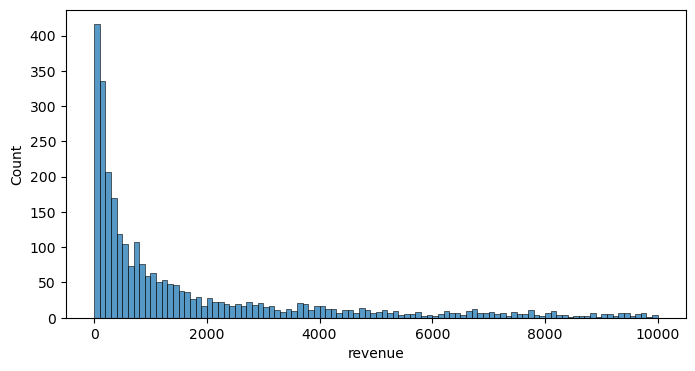

In [8]:
plt.figure(figsize = (8,4))
sns.histplot(data, bins=100, binrange=(0,10000), log_scale=False, x='revenue')

As you can see, the vast majority of sellers achieve total revenues on the platform at a level lower than 2000 RBL, and the largest group has the lowest revenues.

Finally, let's check how many sellers are with revenues above RBL 10,000..

In [16]:
%%sql 
SELECT COUNT(seller_id) AS sellers_10k FROM 
(SELECT o.seller_id, ROUND(SUM(price),2) AS total_revenue FROM order_items o 
LEFT JOIN sellers s ON o.seller_id=s.seller_id 
GROUP BY o.seller_id) as a
WHERE total_revenue > 10000
; 

 * sqlite:///data/olist.db
Done.


sellers_10k
292
